# Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# autoreload if used interactively
%load_ext autoreload
%autoreload 2


# Load UMAP Embedding

We use the 2-D embedding obtained previously (`umap_embedding_2d.csv`) as input for clustering.
Each player is represented by two latent coordinates (UMAP_1, UMAP_2) that capture the main
structures of the high-dimensional performance space.

In [2]:
file_path = "reduced_data/umap/embeddings/joueurs_ligue1_2024_2025_clean_per90_umap5d_best_embedding.csv"
umap_df = pd.read_csv(file_path)
print("✅ UMAP embedding loaded:", umap_df.shape)
umap_df.head() 

✅ UMAP embedding loaded: (333, 11)


,UMAP_1,UMAP_2,UMAP_3,UMAP_4,UMAP_5,player_name,equipe,positions,age,player_id,player_country_code
0,6.495000,6.823001,18.643335,11.675789,-0.964921,Jordan Lefort,Angers,DF,30.0,c3e4ecbb,FRA
1,6.369205,8.471104,21.036950,11.557786,-3.493691,Andrey Santos,Strasbourg,MF,20.0,dd745366,BRA
2,6.091429,8.544127,20.330297,11.707547,-4.401623,Valentin Atangana Edoa,Reims,MF,18.0,6b5edd5d,FRA
3,5.421670,7.865977,21.922668,12.329681,-3.560817,Himad Abdelli,Angers,"MF,FW",24.0,7978cbf0,ALG
4,5.161148,8.017251,23.178370,14.678237,-4.205182,Mason Greenwood,Marseille,"FW,MF",22.0,58eee997,ENG


# Extract Features and Scale

DBSCAN is distance-based; therefore we standardize the 2-D embedding
(even though the scale is usually homogeneous after UMAP).

In [3]:
X = umap_df[['UMAP_1', 'UMAP_2']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Feature matrix shape:", X_scaled.shape)

Feature matrix shape: (333, 2)


# Epsilon Estimation (k-Distance Plot)

The `eps` parameter controls the neighborhood radius.
To select it, we compute the average distance to the *k*-th nearest neighbor
and look for the "elbow" in the curve.


Suggested eps ≈ 0.417 (detected elbow at index 320)


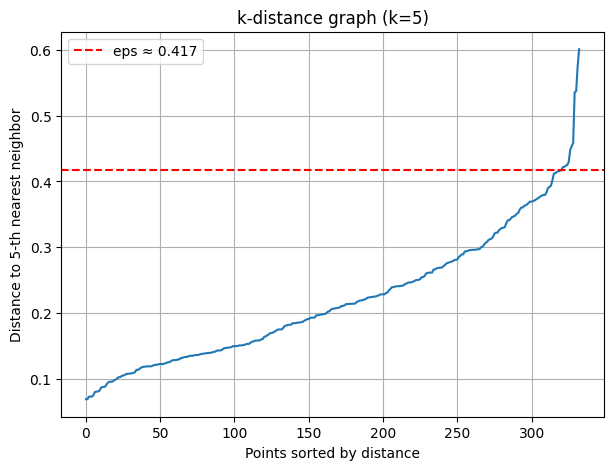

In [4]:
from kneed import KneeLocator

k = 5  # typical choice: min_samples or slightly smaller
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, k-1])  # distance to k-th nearest neighbor

plt.figure(figsize=(7,5))
plt.plot(distances)
plt.title(f"k-distance graph (k={k})")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}-th nearest neighbor")
plt.grid(True)

# Optional automatic elbow detection
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps_est = distances[kneedle.knee] if kneedle.knee is not None else np.median(distances)
if kneedle.knee is not None:
    print(f"Suggested eps ≈ {eps_est:.3f} (detected elbow at index {kneedle.knee})")
else:
    print(f"⚠️ Knee not detected automatically; using median distance as fallback (eps ≈ {eps_est:.3f})") 

plt.axhline(eps_est, color='red', linestyle='--', label=f"eps ≈ {eps_est:.3f}")
plt.legend()
plt.show()


# DBSCAN Clustering

DBSCAN identifies dense regions of players with similar embeddings.
Parameters:
- `eps`: neighborhood radius (set from the elbow).
- `min_samples`: minimum number of points required to form a cluster.
Points not belonging to any dense region are labeled as noise (`-1`).


In [5]:

eps_value = float(eps_est)  # you can tune manually if needed
min_samples_value = 5       # typical range: 3–10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = dbscan.fit_predict(X_scaled)

umap_df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")
umap_df['cluster'].value_counts().sort_index()


DBSCAN found 1 clusters and 2 noise points.


cluster
-1      2
 0    331
Name: count, dtype: int64

# Visualization of Clusters

Each color represents a cluster found by DBSCAN.
Points labeled `-1` (grey) correspond to noise — players not belonging to any dense region.



C:\Users\Josephir\AppData\Local\Temp\ipykernel_34128\2747725269.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


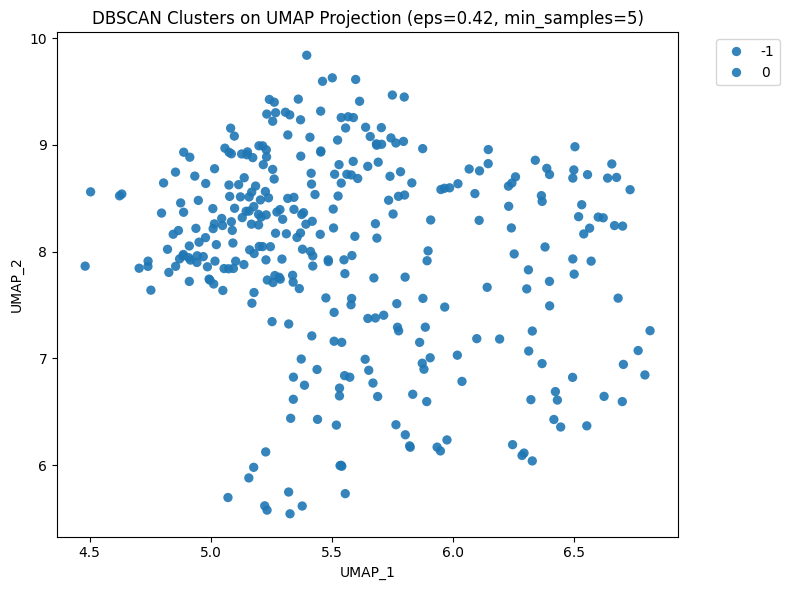

In [6]:
palette = sns.color_palette(None, n_colors=n_clusters)
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=umap_df, x='UMAP_1', y='UMAP_2',
    hue='cluster', palette=palette, s=45, alpha=0.9, edgecolor='none'
)
plt.title(f"DBSCAN Clusters on UMAP Projection (eps={eps_value:.2f}, min_samples={min_samples_value})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Cluster Evaluation

We compute multiple internal validity metrics to assess cluster separation and compactness:
- **Silhouette Coefficient**: higher = better separation (range: -1 to +1)
- **Calinski–Harabasz Index**: higher = better defined clusters
- **Davies–Bouldin Index**: lower = better separation (0 = ideal)


In [7]:
mask = umap_df['cluster'] != -1  # exclude noise for metric computation
if mask.sum() > 1 and n_clusters > 1:
    silhouette = silhouette_score(X_scaled[mask], umap_df.loc[mask, 'cluster'])
    ch_index = calinski_harabasz_score(X_scaled[mask], umap_df.loc[mask, 'cluster'])
    db_index = davies_bouldin_score(X_scaled[mask], umap_df.loc[mask, 'cluster'])

    print("\n🔍 Cluster Evaluation Metrics (excluding noise):")
    print(f"Silhouette Score        : {silhouette:.3f}")
    print(f"Calinski–Harabasz Index : {ch_index:.3f}")
    print(f"Davies–Bouldin Index    : {db_index:.3f}")
else:
    print("Cluster evaluation metrics not meaningful (too few clusters or too much noise).")

Cluster evaluation metrics not meaningful (too few clusters or too much noise).


Silhouette score without noise is 0.571
Is that a good score for DBSCAN? Generally, a silhouette score above 0.5 indicates reasonable clustering structure.

# Cluster Analysis by Player Attributes

We inspect the distribution of positions, ages, and teams within each cluster
to interpret what kinds of players DBSCAN groups together.



In [8]:
cluster_summary = (
    umap_df.groupby('cluster')
    .agg({
        'age': ['count', 'mean'],
        'positions': lambda x: ', '.join(x.value_counts().index[:3]) if len(x.value_counts()) > 0 else None,
        'equipe': lambda x: ', '.join(x.value_counts().index[:3]) if len(x.value_counts()) > 0 else None
    })
    .round(2)
)
cluster_summary


age             positions                        equipe
        count   mean       <lambda>                      <lambda>
cluster                                                          
-1          2  25.00         DF, FW              Brest, Marseille
 0        331  25.02  DF, MF, FW,MF  Le Havre, Saint, Montpellier

# Visualization – Cluster Composition by Position

We visualize how player positions are distributed across clusters.



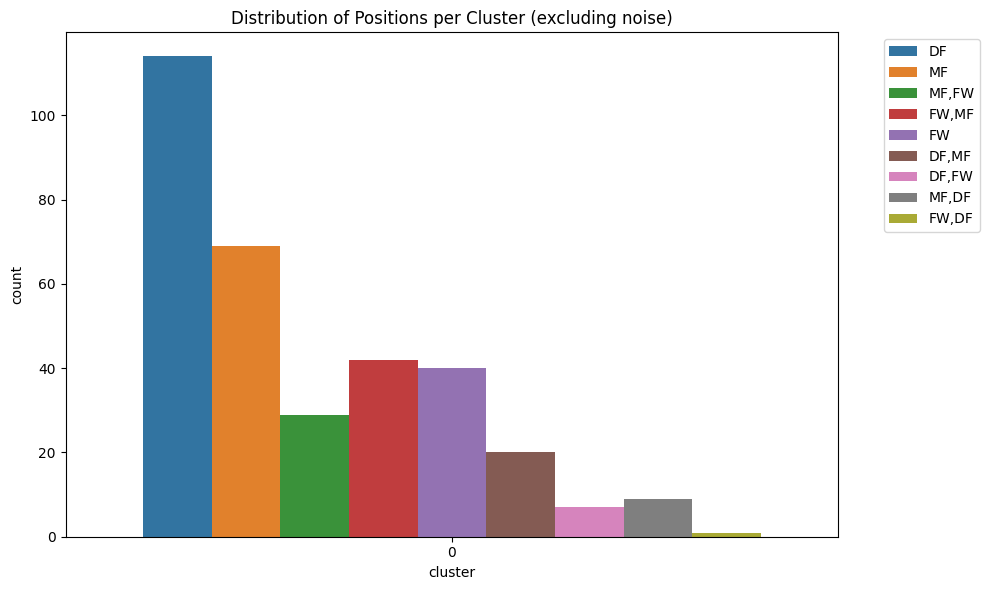

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(
    data=umap_df[umap_df['cluster'] != -1],
    x='cluster', hue='positions', palette='tab10'
)
plt.title("Distribution of Positions per Cluster (excluding noise)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save Clustered Dataset

The resulting table can be reused for Agglomerative clustering or profile analysis.


In [10]:

output_path = "reduced_data/umap_dbscan_clusters.csv"
umap_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Clustered dataset exported to {output_path}")


✅ Clustered dataset exported to reduced_data/umap_dbscan_clusters.csv


In [11]:
# %% [markdown]
# # Summary
#
# - **DBSCAN** successfully detected groups of players with similar statistical profiles in the UMAP space.  
# - Noise points represent players whose profiles are atypical or lie between defined roles.  
# - The silhouette score provides a quantitative measure of separation quality.  
# - The next step is to compare these results with **Agglomerative Clustering** to evaluate stability and interpretability of group structures.


In [ ]:
# original

# def resolve_embedding_file_for_method2(method: str) -> str:
#     """
#     Return the single embedding CSV path to cluster for a given method.
#       - umap: select via best MSE from best_results/.
#       - pca:  PCA_custom.csv
#       - tsne: tSNE_custom_GK.csv
#       - isomap: ISOMAP_raw.csv

#     Raises if the file is missing.
#     """
#     m = method.lower()
#     if m == "umap":
#         return select_best_umap_embedding_path()
#     elif m == "pca":
#         if not os.path.isfile(PCA_EMB_FILE):
#             raise FileNotFoundError(f"Missing PCA embedding: {PCA_EMB_FILE}")
#         return PCA_EMB_FILE
#     elif m == "tsne":
#         if not os.path.isfile(TSNE_EMB_FILE):
#             raise FileNotFoundError(f"Missing t-SNE embedding: {TSNE_EMB_FILE}")
#         return TSNE_EMB_FILE
#     elif m == "isomap":
#         if not os.path.isfile(ISOMAP_EMB_FILE):
#             raise FileNotFoundError(f"Missing Isomap embedding: {ISOMAP_EMB_FILE}")
#         return ISOMAP_EMB_FILE
#     else:
#         raise ValueError(f"Unsupported method: {method}")
